In [1]:
# General Ievit model
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../backbone","../.."])
from densenet201 import DenseNet201b
from dataloader import create_dataloader
from metric import Metric
from ievit import IEViT
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
# device = torch.device("cuda:0")
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
in_channel = 3
image_size = 384
patch_size = 16
num_workers = 4
embed_dim = 960
mlp_dim = 1024
dim_feedforward = 1024
num_layers = 12
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../mured-data/data'

In [3]:
# Create dataloaders (image.shape = torch.Size([batch_size, channel_no, H, W])
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone = DenseNet201b(embed_dim)
# create an instance of IEVIT
model = IEViT(image_size, patch_size = patch_size, in_channels = in_channel, num_classes = num_classes, embed_dim = embed_dim,
               num_heads = num_workers, num_layers = num_layers, dim_feedforward = dim_feedforward, mlp_dim = mlp_dim, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()
# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0]

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels, 0)
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels,1)
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()      

Epoch 1/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [1/200], Loss: 0.3399, ML mAP: 0.0885, ML F1: 0.0503, ML AUC: 0.5189, ML Score: 0.3037, Bin AUC: 0.1053, Model Score: 0.2045, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [1/200], Loss: 0.3399, ML mAP: 0.1892, ML F1: 0.0123, ML AUC: 0.7788, ML Score: 0.4840, Bin AUC: 0.9474, Model Score: 0.7157, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [2/200], Loss: 0.2430, ML mAP: 0.1578, ML F1: 0.0878, ML AUC: 0.6656, ML Score: 0.4117, Bin AUC: 0.5278, Model Score: 0.4698, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [2/200], Loss: 0.2430, ML mAP: 0.3169, ML F1: 0.0739, ML AUC: 0.8520, ML Score: 0.5844, Bin AUC: 0.3684, Model Score: 0.4764, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [3/200], Loss: 0.3220, ML mAP: 0.2462, ML F1: 0.1650, ML AUC: 0.7628, ML Score: 0.5045, Bin AUC: 1.0000, Model Score: 0.7522, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [3/200], Loss: 0.3220, ML mAP: 0.3789, ML F1: 0.0654, ML AUC: 0.8821, ML Score: 0.6305, Bin AUC: 0.6842, Model Score: 0.6574, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [4/200], Loss: 0.2129, ML mAP: 0.3628, ML F1: 0.2584, ML AUC: 0.8304, ML Score: 0.5966, Bin AUC: 0.6944, Model Score: 0.6455, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [4/200], Loss: 0.2129, ML mAP: 0.4593, ML F1: 0.1768, ML AUC: 0.9011, ML Score: 0.6802, Bin AUC: 0.8947, Model Score: 0.7875, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [5/200], Loss: 0.1922, ML mAP: 0.4419, ML F1: 0.3409, ML AUC: 0.8691, ML Score: 0.6555, Bin AUC: 0.6316, Model Score: 0.6435, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [5/200], Loss: 0.1922, ML mAP: 0.4859, ML F1: 0.2358, ML AUC: 0.9093, ML Score: 0.6976, Bin AUC: 0.7368, Model Score: 0.7172, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [6/200], Loss: 0.1933, ML mAP: 0.5473, ML F1: 0.4270, ML AUC: 0.9064, ML Score: 0.7268, Bin AUC: 0.5556, Model Score: 0.6412, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [6/200], Loss: 0.1933, ML mAP: 0.5032, ML F1: 0.2748, ML AUC: 0.9180, ML Score: 0.7106, Bin AUC: 0.8421, Model Score: 0.7764, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [7/200], Loss: 0.2852, ML mAP: 0.6245, ML F1: 0.4940, ML AUC: 0.9259, ML Score: 0.7752, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [7/200], Loss: 0.2852, ML mAP: 0.5267, ML F1: 0.3345, ML AUC: 0.9212, ML Score: 0.7240, Bin AUC: 0.6842, Model Score: 0.7041, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [8/200], Loss: 0.1451, ML mAP: 0.6847, ML F1: 0.5591, ML AUC: 0.9412, ML Score: 0.8130, Bin AUC: 0.7368, Model Score: 0.7749, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [8/200], Loss: 0.1451, ML mAP: 0.5527, ML F1: 0.4078, ML AUC: 0.9254, ML Score: 0.7391, Bin AUC: 0.8421, Model Score: 0.7906, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [9/200], Loss: 0.1046, ML mAP: 0.7289, ML F1: 0.5930, ML AUC: 0.9512, ML Score: 0.8401, Bin AUC: 0.9804, Model Score: 0.9102, Bin F1: 0.8000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [9/200], Loss: 0.1046, ML mAP: 0.5534, ML F1: 0.3496, ML AUC: 0.9260, ML Score: 0.7397, Bin AUC: 0.7368, Model Score: 0.7383, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [10/200], Loss: 0.1672, ML mAP: 0.7686, ML F1: 0.6064, ML AUC: 0.9567, ML Score: 0.8627, Bin AUC: 1.0000, Model Score: 0.9313, Bin F1: 0.8000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [10/200], Loss: 0.1672, ML mAP: 0.5532, ML F1: 0.3649, ML AUC: 0.9255, ML Score: 0.7393, Bin AUC: 0.8421, Model Score: 0.7907, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [11/200], Loss: 0.0914, ML mAP: 0.6332, ML F1: 0.5535, ML AUC: 0.9250, ML Score: 0.7791, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [11/200], Loss: 0.0914, ML mAP: 0.5505, ML F1: 0.2257, ML AUC: 0.9283, ML Score: 0.7394, Bin AUC: 0.4737, Model Score: 0.6065, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [12/200], Loss: 0.1710, ML mAP: 0.6568, ML F1: 0.6059, ML AUC: 0.9330, ML Score: 0.7949, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [12/200], Loss: 0.1710, ML mAP: 0.5861, ML F1: 0.4267, ML AUC: 0.9293, ML Score: 0.7577, Bin AUC: 0.7895, Model Score: 0.7736, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [13/200], Loss: 0.2146, ML mAP: 0.7217, ML F1: 0.6443, ML AUC: 0.9485, ML Score: 0.8351, Bin AUC: 1.0000, Model Score: 0.9175, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [13/200], Loss: 0.2146, ML mAP: 0.6114, ML F1: 0.4655, ML AUC: 0.9295, ML Score: 0.7705, Bin AUC: 0.6316, Model Score: 0.7010, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [14/200], Loss: 0.1328, ML mAP: 0.7866, ML F1: 0.7130, ML AUC: 0.9619, ML Score: 0.8743, Bin AUC: 1.0000, Model Score: 0.9371, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [14/200], Loss: 0.1328, ML mAP: 0.6150, ML F1: 0.5088, ML AUC: 0.9319, ML Score: 0.7735, Bin AUC: 0.7895, Model Score: 0.7815, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [15/200], Loss: 0.1076, ML mAP: 0.7964, ML F1: 0.7332, ML AUC: 0.9642, ML Score: 0.8803, Bin AUC: 0.8594, Model Score: 0.8698, Bin F1: 0.5714


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [15/200], Loss: 0.1076, ML mAP: 0.6011, ML F1: 0.4680, ML AUC: 0.9343, ML Score: 0.7677, Bin AUC: 0.8947, Model Score: 0.8312, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [16/200], Loss: 0.0499, ML mAP: 0.8292, ML F1: 0.7566, ML AUC: 0.9714, ML Score: 0.9003, Bin AUC: 0.8947, Model Score: 0.8975, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [16/200], Loss: 0.0499, ML mAP: 0.6364, ML F1: 0.5650, ML AUC: 0.9374, ML Score: 0.7869, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [17/200], Loss: 0.0650, ML mAP: 0.8669, ML F1: 0.8062, ML AUC: 0.9775, ML Score: 0.9222, Bin AUC: 1.0000, Model Score: 0.9611, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [17/200], Loss: 0.0650, ML mAP: 0.6376, ML F1: 0.5531, ML AUC: 0.9381, ML Score: 0.7878, Bin AUC: 0.9474, Model Score: 0.8676, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [18/200], Loss: 0.0393, ML mAP: 0.8911, ML F1: 0.8219, ML AUC: 0.9810, ML Score: 0.9361, Bin AUC: 1.0000, Model Score: 0.9680, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [18/200], Loss: 0.0393, ML mAP: 0.6443, ML F1: 0.5465, ML AUC: 0.9398, ML Score: 0.7920, Bin AUC: 0.7368, Model Score: 0.7644, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [19/200], Loss: 0.0504, ML mAP: 0.9236, ML F1: 0.8555, ML AUC: 0.9887, ML Score: 0.9561, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [19/200], Loss: 0.0504, ML mAP: 0.6638, ML F1: 0.5875, ML AUC: 0.9443, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [20/200], Loss: 0.0674, ML mAP: 0.9216, ML F1: 0.8632, ML AUC: 0.9884, ML Score: 0.9550, Bin AUC: 0.8947, Model Score: 0.9249, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [20/200], Loss: 0.0674, ML mAP: 0.6734, ML F1: 0.5951, ML AUC: 0.9475, ML Score: 0.8104, Bin AUC: 0.8947, Model Score: 0.8526, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [21/200], Loss: 0.0329, ML mAP: 0.9400, ML F1: 0.8883, ML AUC: 0.9914, ML Score: 0.9657, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [21/200], Loss: 0.0329, ML mAP: 0.6713, ML F1: 0.6015, ML AUC: 0.9532, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [22/200], Loss: 0.0234, ML mAP: 0.9579, ML F1: 0.9076, ML AUC: 0.9944, ML Score: 0.9762, Bin AUC: 1.0000, Model Score: 0.9881, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [22/200], Loss: 0.0234, ML mAP: 0.6491, ML F1: 0.5700, ML AUC: 0.9473, ML Score: 0.7982, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 0.0000

Epoch 23/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [23/200], Loss: 0.0934, ML mAP: 0.9528, ML F1: 0.9070, ML AUC: 0.9941, ML Score: 0.9735, Bin AUC: 1.0000, Model Score: 0.9867, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [23/200], Loss: 0.0934, ML mAP: 0.6546, ML F1: 0.5719, ML AUC: 0.9433, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [24/200], Loss: 0.0427, ML mAP: 0.9628, ML F1: 0.9190, ML AUC: 0.9951, ML Score: 0.9789, Bin AUC: 1.0000, Model Score: 0.9895, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [24/200], Loss: 0.0427, ML mAP: 0.6580, ML F1: 0.5917, ML AUC: 0.9479, ML Score: 0.8029, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 0.0000

Epoch 25/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [25/200], Loss: 0.0295, ML mAP: 0.9646, ML F1: 0.9299, ML AUC: 0.9961, ML Score: 0.9804, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [25/200], Loss: 0.0295, ML mAP: 0.6631, ML F1: 0.5950, ML AUC: 0.9486, ML Score: 0.8059, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.0000

Epoch 26/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [26/200], Loss: 0.0564, ML mAP: 0.9735, ML F1: 0.9339, ML AUC: 0.9960, ML Score: 0.9847, Bin AUC: 1.0000, Model Score: 0.9924, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [26/200], Loss: 0.0564, ML mAP: 0.6519, ML F1: 0.5921, ML AUC: 0.9483, ML Score: 0.8001, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [27/200], Loss: 0.0416, ML mAP: 0.9800, ML F1: 0.9431, ML AUC: 0.9972, ML Score: 0.9886, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [27/200], Loss: 0.0416, ML mAP: 0.6569, ML F1: 0.5863, ML AUC: 0.9493, ML Score: 0.8031, Bin AUC: 1.0000, Model Score: 0.9016, Bin F1: 0.0000

Epoch 28/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [28/200], Loss: 0.0245, ML mAP: 0.9782, ML F1: 0.9432, ML AUC: 0.9971, ML Score: 0.9877, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Val - Epoch [28/200], Loss: 0.0245, ML mAP: 0.6595, ML F1: 0.5831, ML AUC: 0.9491, ML Score: 0.8043, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [29/200], Loss: 0.0226, ML mAP: 0.9813, ML F1: 0.9487, ML AUC: 0.9979, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [29/200], Loss: 0.0226, ML mAP: 0.6539, ML F1: 0.6089, ML AUC: 0.9483, ML Score: 0.8011, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 0.0000

Epoch 30/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [30/200], Loss: 0.0788, ML mAP: 0.9815, ML F1: 0.9495, ML AUC: 0.9978, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 0.8000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [30/200], Loss: 0.0788, ML mAP: 0.6603, ML F1: 0.6035, ML AUC: 0.9496, ML Score: 0.8050, Bin AUC: 1.0000, Model Score: 0.9025, Bin F1: 0.0000

Epoch 31/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [31/200], Loss: 0.0815, ML mAP: 0.9365, ML F1: 0.8782, ML AUC: 0.9909, ML Score: 0.9637, Bin AUC: 1.0000, Model Score: 0.9818, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [31/200], Loss: 0.0815, ML mAP: 0.6366, ML F1: 0.5865, ML AUC: 0.9368, ML Score: 0.7867, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000

Epoch 32/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [32/200], Loss: 0.0649, ML mAP: 0.9183, ML F1: 0.8587, ML AUC: 0.9887, ML Score: 0.9535, Bin AUC: 1.0000, Model Score: 0.9767, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [32/200], Loss: 0.0649, ML mAP: 0.6595, ML F1: 0.5881, ML AUC: 0.9423, ML Score: 0.8009, Bin AUC: 0.9474, Model Score: 0.8741, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [33/200], Loss: 0.0701, ML mAP: 0.9175, ML F1: 0.8557, ML AUC: 0.9892, ML Score: 0.9533, Bin AUC: 1.0000, Model Score: 0.9767, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [33/200], Loss: 0.0701, ML mAP: 0.6454, ML F1: 0.5774, ML AUC: 0.9343, ML Score: 0.7898, Bin AUC: 1.0000, Model Score: 0.8949, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [34/200], Loss: 0.1031, ML mAP: 0.9275, ML F1: 0.8783, ML AUC: 0.9882, ML Score: 0.9579, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [34/200], Loss: 0.1031, ML mAP: 0.6384, ML F1: 0.5633, ML AUC: 0.9347, ML Score: 0.7865, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [35/200], Loss: 0.0702, ML mAP: 0.9410, ML F1: 0.8813, ML AUC: 0.9920, ML Score: 0.9665, Bin AUC: 1.0000, Model Score: 0.9832, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [35/200], Loss: 0.0702, ML mAP: 0.6579, ML F1: 0.6001, ML AUC: 0.9465, ML Score: 0.8022, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [36/200], Loss: 0.1707, ML mAP: 0.9503, ML F1: 0.8955, ML AUC: 0.9932, ML Score: 0.9718, Bin AUC: 1.0000, Model Score: 0.9859, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [36/200], Loss: 0.1707, ML mAP: 0.6427, ML F1: 0.5890, ML AUC: 0.9409, ML Score: 0.7918, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 1.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [37/200], Loss: 0.0514, ML mAP: 0.9455, ML F1: 0.8998, ML AUC: 0.9927, ML Score: 0.9691, Bin AUC: 1.0000, Model Score: 0.9845, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [37/200], Loss: 0.0514, ML mAP: 0.6568, ML F1: 0.6127, ML AUC: 0.9447, ML Score: 0.8008, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [38/200], Loss: 0.0912, ML mAP: 0.9577, ML F1: 0.9158, ML AUC: 0.9952, ML Score: 0.9764, Bin AUC: 1.0000, Model Score: 0.9882, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [38/200], Loss: 0.0912, ML mAP: 0.6406, ML F1: 0.5862, ML AUC: 0.9389, ML Score: 0.7897, Bin AUC: 1.0000, Model Score: 0.8949, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [39/200], Loss: 0.1299, ML mAP: 0.9561, ML F1: 0.9057, ML AUC: 0.9951, ML Score: 0.9756, Bin AUC: 1.0000, Model Score: 0.9878, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [39/200], Loss: 0.1299, ML mAP: 0.6637, ML F1: 0.6099, ML AUC: 0.9395, ML Score: 0.8016, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [40/200], Loss: 0.0321, ML mAP: 0.9726, ML F1: 0.9298, ML AUC: 0.9959, ML Score: 0.9842, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [40/200], Loss: 0.0321, ML mAP: 0.6521, ML F1: 0.6086, ML AUC: 0.9345, ML Score: 0.7933, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [41/200], Loss: 0.0373, ML mAP: 0.9691, ML F1: 0.9262, ML AUC: 0.9950, ML Score: 0.9821, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [41/200], Loss: 0.0373, ML mAP: 0.6648, ML F1: 0.5866, ML AUC: 0.9366, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [42/200], Loss: 0.1584, ML mAP: 0.9733, ML F1: 0.9304, ML AUC: 0.9966, ML Score: 0.9850, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [42/200], Loss: 0.1584, ML mAP: 0.6631, ML F1: 0.5836, ML AUC: 0.9392, ML Score: 0.8011, Bin AUC: 0.8947, Model Score: 0.8479, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [43/200], Loss: 0.0624, ML mAP: 0.9705, ML F1: 0.9331, ML AUC: 0.9967, ML Score: 0.9836, Bin AUC: 0.8889, Model Score: 0.9363, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [43/200], Loss: 0.0624, ML mAP: 0.6454, ML F1: 0.6009, ML AUC: 0.9357, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [44/200], Loss: 0.1713, ML mAP: 0.9736, ML F1: 0.9359, ML AUC: 0.9968, ML Score: 0.9852, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [44/200], Loss: 0.1713, ML mAP: 0.6540, ML F1: 0.5988, ML AUC: 0.9365, ML Score: 0.7953, Bin AUC: 0.9474, Model Score: 0.8713, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [45/200], Loss: 0.0565, ML mAP: 0.9743, ML F1: 0.9395, ML AUC: 0.9970, ML Score: 0.9857, Bin AUC: 0.9804, Model Score: 0.9830, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [45/200], Loss: 0.0565, ML mAP: 0.6451, ML F1: 0.6045, ML AUC: 0.9328, ML Score: 0.7890, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [46/200], Loss: 0.0427, ML mAP: 0.9823, ML F1: 0.9476, ML AUC: 0.9980, ML Score: 0.9901, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [46/200], Loss: 0.0427, ML mAP: 0.6566, ML F1: 0.5787, ML AUC: 0.9355, ML Score: 0.7960, Bin AUC: 0.9474, Model Score: 0.8717, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [47/200], Loss: 0.1216, ML mAP: 0.9830, ML F1: 0.9509, ML AUC: 0.9983, ML Score: 0.9907, Bin AUC: 0.9722, Model Score: 0.9814, Bin F1: 0.5000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [47/200], Loss: 0.1216, ML mAP: 0.6470, ML F1: 0.5889, ML AUC: 0.9382, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 0.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [48/200], Loss: 0.0073, ML mAP: 0.9886, ML F1: 0.9590, ML AUC: 0.9988, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [48/200], Loss: 0.0073, ML mAP: 0.6563, ML F1: 0.6352, ML AUC: 0.9318, ML Score: 0.7940, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [49/200], Loss: 0.0774, ML mAP: 0.9887, ML F1: 0.9632, ML AUC: 0.9987, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [49/200], Loss: 0.0774, ML mAP: 0.6547, ML F1: 0.6042, ML AUC: 0.9323, ML Score: 0.7935, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [50/200], Loss: 0.0075, ML mAP: 0.9909, ML F1: 0.9681, ML AUC: 0.9992, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [50/200], Loss: 0.0075, ML mAP: 0.6513, ML F1: 0.5728, ML AUC: 0.9289, ML Score: 0.7901, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [51/200], Loss: 0.0079, ML mAP: 0.9907, ML F1: 0.9688, ML AUC: 0.9991, ML Score: 0.9949, Bin AUC: 0.8947, Model Score: 0.9448, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [51/200], Loss: 0.0079, ML mAP: 0.6405, ML F1: 0.5961, ML AUC: 0.9339, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [52/200], Loss: 0.0774, ML mAP: 0.9913, ML F1: 0.9711, ML AUC: 0.9990, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [52/200], Loss: 0.0774, ML mAP: 0.6406, ML F1: 0.6016, ML AUC: 0.9288, ML Score: 0.7847, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [53/200], Loss: 0.0428, ML mAP: 0.9930, ML F1: 0.9752, ML AUC: 0.9992, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [53/200], Loss: 0.0428, ML mAP: 0.6585, ML F1: 0.6341, ML AUC: 0.9352, ML Score: 0.7969, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [54/200], Loss: 0.0676, ML mAP: 0.9948, ML F1: 0.9733, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [54/200], Loss: 0.0676, ML mAP: 0.6476, ML F1: 0.6129, ML AUC: 0.9354, ML Score: 0.7915, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [55/200], Loss: 0.0878, ML mAP: 0.9943, ML F1: 0.9770, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [55/200], Loss: 0.0878, ML mAP: 0.6544, ML F1: 0.6404, ML AUC: 0.9379, ML Score: 0.7961, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [56/200], Loss: 0.0018, ML mAP: 0.9941, ML F1: 0.9760, ML AUC: 0.9995, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [56/200], Loss: 0.0018, ML mAP: 0.6613, ML F1: 0.6121, ML AUC: 0.9399, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [57/200], Loss: 0.1667, ML mAP: 0.9948, ML F1: 0.9751, ML AUC: 0.9991, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [57/200], Loss: 0.1667, ML mAP: 0.6628, ML F1: 0.6273, ML AUC: 0.9384, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [58/200], Loss: 0.0047, ML mAP: 0.9951, ML F1: 0.9810, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [58/200], Loss: 0.0047, ML mAP: 0.6359, ML F1: 0.6038, ML AUC: 0.9356, ML Score: 0.7858, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [59/200], Loss: 0.0047, ML mAP: 0.9963, ML F1: 0.9804, ML AUC: 0.9993, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [59/200], Loss: 0.0047, ML mAP: 0.6406, ML F1: 0.5969, ML AUC: 0.9383, ML Score: 0.7894, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [60/200], Loss: 0.0515, ML mAP: 0.9968, ML F1: 0.9850, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Val - Epoch [60/200], Loss: 0.0515, ML mAP: 0.6487, ML F1: 0.6119, ML AUC: 0.9409, ML Score: 0.7948, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [61/200], Loss: 0.0164, ML mAP: 0.9968, ML F1: 0.9845, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [61/200], Loss: 0.0164, ML mAP: 0.6561, ML F1: 0.6257, ML AUC: 0.9418, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [62/200], Loss: 0.0012, ML mAP: 0.9974, ML F1: 0.9843, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [62/200], Loss: 0.0012, ML mAP: 0.6622, ML F1: 0.6216, ML AUC: 0.9424, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [63/200], Loss: 0.0012, ML mAP: 0.9976, ML F1: 0.9871, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [63/200], Loss: 0.0012, ML mAP: 0.6576, ML F1: 0.6224, ML AUC: 0.9422, ML Score: 0.7999, Bin AUC: 1.0000, Model Score: 0.8999, Bin F1: 0.0000

Epoch 64/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [64/200], Loss: 0.0024, ML mAP: 0.9974, ML F1: 0.9849, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [64/200], Loss: 0.0024, ML mAP: 0.6568, ML F1: 0.6163, ML AUC: 0.9413, ML Score: 0.7990, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [65/200], Loss: 0.0205, ML mAP: 0.9973, ML F1: 0.9881, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [65/200], Loss: 0.0205, ML mAP: 0.6584, ML F1: 0.6201, ML AUC: 0.9429, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [66/200], Loss: 0.0347, ML mAP: 0.9982, ML F1: 0.9879, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [66/200], Loss: 0.0347, ML mAP: 0.6554, ML F1: 0.6187, ML AUC: 0.9420, ML Score: 0.7987, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [67/200], Loss: 0.1334, ML mAP: 0.9984, ML F1: 0.9868, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [67/200], Loss: 0.1334, ML mAP: 0.6574, ML F1: 0.6201, ML AUC: 0.9429, ML Score: 0.8001, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [68/200], Loss: 0.0638, ML mAP: 0.9982, ML F1: 0.9904, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [68/200], Loss: 0.0638, ML mAP: 0.6569, ML F1: 0.6208, ML AUC: 0.9411, ML Score: 0.7990, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [69/200], Loss: 0.0282, ML mAP: 0.9992, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [69/200], Loss: 0.0282, ML mAP: 0.6587, ML F1: 0.6309, ML AUC: 0.9393, ML Score: 0.7990, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [70/200], Loss: 0.0859, ML mAP: 0.9981, ML F1: 0.9869, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [70/200], Loss: 0.0859, ML mAP: 0.6598, ML F1: 0.6327, ML AUC: 0.9423, ML Score: 0.8011, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [71/200], Loss: 0.0137, ML mAP: 0.9739, ML F1: 0.9355, ML AUC: 0.9962, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [71/200], Loss: 0.0137, ML mAP: 0.6233, ML F1: 0.5224, ML AUC: 0.9275, ML Score: 0.7754, Bin AUC: 0.8947, Model Score: 0.8351, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [72/200], Loss: 0.0457, ML mAP: 0.9404, ML F1: 0.8834, ML AUC: 0.9916, ML Score: 0.9660, Bin AUC: 0.9804, Model Score: 0.9732, Bin F1: 0.8571


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [72/200], Loss: 0.0457, ML mAP: 0.6524, ML F1: 0.5805, ML AUC: 0.9271, ML Score: 0.7898, Bin AUC: 0.9474, Model Score: 0.8686, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [73/200], Loss: 0.0405, ML mAP: 0.9588, ML F1: 0.9117, ML AUC: 0.9952, ML Score: 0.9770, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Val - Epoch [73/200], Loss: 0.0405, ML mAP: 0.6081, ML F1: 0.5390, ML AUC: 0.9250, ML Score: 0.7665, Bin AUC: 0.6842, Model Score: 0.7254, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [74/200], Loss: 0.0504, ML mAP: 0.9719, ML F1: 0.9315, ML AUC: 0.9965, ML Score: 0.9842, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [74/200], Loss: 0.0504, ML mAP: 0.6190, ML F1: 0.5747, ML AUC: 0.9282, ML Score: 0.7736, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [75/200], Loss: 0.0887, ML mAP: 0.9694, ML F1: 0.9247, ML AUC: 0.9964, ML Score: 0.9829, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Val - Epoch [75/200], Loss: 0.0887, ML mAP: 0.6571, ML F1: 0.5609, ML AUC: 0.9282, ML Score: 0.7926, Bin AUC: 0.9474, Model Score: 0.8700, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [76/200], Loss: 0.1331, ML mAP: 0.9824, ML F1: 0.9440, ML AUC: 0.9975, ML Score: 0.9899, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Val - Epoch [76/200], Loss: 0.1331, ML mAP: 0.6419, ML F1: 0.5506, ML AUC: 0.9323, ML Score: 0.7871, Bin AUC: 0.7368, Model Score: 0.7620, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [77/200], Loss: 0.0434, ML mAP: 0.9815, ML F1: 0.9471, ML AUC: 0.9979, ML Score: 0.9897, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [77/200], Loss: 0.0434, ML mAP: 0.6344, ML F1: 0.6114, ML AUC: 0.9276, ML Score: 0.7810, Bin AUC: 0.8421, Model Score: 0.8115, Bin F1: 0.0000

Epoch 78/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [78/200], Loss: 0.0454, ML mAP: 0.9775, ML F1: 0.9378, ML AUC: 0.9973, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [78/200], Loss: 0.0454, ML mAP: 0.6436, ML F1: 0.6016, ML AUC: 0.9331, ML Score: 0.7883, Bin AUC: 0.9474, Model Score: 0.8678, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [79/200], Loss: 0.0282, ML mAP: 0.9726, ML F1: 0.9323, ML AUC: 0.9966, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Val - Epoch [79/200], Loss: 0.0282, ML mAP: 0.6596, ML F1: 0.6265, ML AUC: 0.9332, ML Score: 0.7964, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [80/200], Loss: 0.1313, ML mAP: 0.9850, ML F1: 0.9547, ML AUC: 0.9984, ML Score: 0.9917, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [80/200], Loss: 0.1313, ML mAP: 0.6442, ML F1: 0.6157, ML AUC: 0.9239, ML Score: 0.7840, Bin AUC: 1.0000, Model Score: 0.8920, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [81/200], Loss: 0.0189, ML mAP: 0.9872, ML F1: 0.9538, ML AUC: 0.9986, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [81/200], Loss: 0.0189, ML mAP: 0.6418, ML F1: 0.5851, ML AUC: 0.9305, ML Score: 0.7861, Bin AUC: 0.8947, Model Score: 0.8404, Bin F1: 0.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [82/200], Loss: 0.0159, ML mAP: 0.9896, ML F1: 0.9671, ML AUC: 0.9989, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [82/200], Loss: 0.0159, ML mAP: 0.6446, ML F1: 0.5906, ML AUC: 0.9261, ML Score: 0.7853, Bin AUC: 0.8421, Model Score: 0.8137, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [83/200], Loss: 0.0096, ML mAP: 0.9895, ML F1: 0.9678, ML AUC: 0.9989, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Val - Epoch [83/200], Loss: 0.0096, ML mAP: 0.6555, ML F1: 0.6041, ML AUC: 0.9302, ML Score: 0.7928, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 0.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [84/200], Loss: 0.0914, ML mAP: 0.9853, ML F1: 0.9612, ML AUC: 0.9982, ML Score: 0.9918, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [84/200], Loss: 0.0914, ML mAP: 0.6332, ML F1: 0.6054, ML AUC: 0.9287, ML Score: 0.7810, Bin AUC: 0.9474, Model Score: 0.8642, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [85/200], Loss: 0.0641, ML mAP: 0.9874, ML F1: 0.9557, ML AUC: 0.9986, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [85/200], Loss: 0.0641, ML mAP: 0.6411, ML F1: 0.6131, ML AUC: 0.9360, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [86/200], Loss: 0.0125, ML mAP: 0.9895, ML F1: 0.9648, ML AUC: 0.9985, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [86/200], Loss: 0.0125, ML mAP: 0.6423, ML F1: 0.6378, ML AUC: 0.9375, ML Score: 0.7899, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [87/200], Loss: 0.0035, ML mAP: 0.9910, ML F1: 0.9690, ML AUC: 0.9988, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [87/200], Loss: 0.0035, ML mAP: 0.6380, ML F1: 0.5754, ML AUC: 0.9348, ML Score: 0.7864, Bin AUC: 0.8421, Model Score: 0.8142, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [88/200], Loss: 0.0095, ML mAP: 0.9917, ML F1: 0.9720, ML AUC: 0.9988, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [88/200], Loss: 0.0095, ML mAP: 0.6454, ML F1: 0.5769, ML AUC: 0.9417, ML Score: 0.7936, Bin AUC: 0.9474, Model Score: 0.8705, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [89/200], Loss: 0.2111, ML mAP: 0.9901, ML F1: 0.9661, ML AUC: 0.9988, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [89/200], Loss: 0.2111, ML mAP: 0.6299, ML F1: 0.5817, ML AUC: 0.9281, ML Score: 0.7790, Bin AUC: 1.0000, Model Score: 0.8895, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [90/200], Loss: 0.0733, ML mAP: 0.9830, ML F1: 0.9474, ML AUC: 0.9982, ML Score: 0.9906, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [90/200], Loss: 0.0733, ML mAP: 0.6306, ML F1: 0.6084, ML AUC: 0.9322, ML Score: 0.7814, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [91/200], Loss: 0.0526, ML mAP: 0.9911, ML F1: 0.9638, ML AUC: 0.9989, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [91/200], Loss: 0.0526, ML mAP: 0.6631, ML F1: 0.6191, ML AUC: 0.9346, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 0.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [92/200], Loss: 0.0293, ML mAP: 0.9926, ML F1: 0.9717, ML AUC: 0.9991, ML Score: 0.9959, Bin AUC: 0.9804, Model Score: 0.9881, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [92/200], Loss: 0.0293, ML mAP: 0.6433, ML F1: 0.6197, ML AUC: 0.9298, ML Score: 0.7866, Bin AUC: 0.8421, Model Score: 0.8143, Bin F1: 0.0000

Epoch 93/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [93/200], Loss: 0.0634, ML mAP: 0.9898, ML F1: 0.9665, ML AUC: 0.9990, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [93/200], Loss: 0.0634, ML mAP: 0.6375, ML F1: 0.6096, ML AUC: 0.9335, ML Score: 0.7855, Bin AUC: 0.8421, Model Score: 0.8138, Bin F1: 0.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [94/200], Loss: 0.1879, ML mAP: 0.9945, ML F1: 0.9753, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [94/200], Loss: 0.1879, ML mAP: 0.6362, ML F1: 0.5826, ML AUC: 0.9319, ML Score: 0.7840, Bin AUC: 0.7895, Model Score: 0.7867, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [95/200], Loss: 0.0080, ML mAP: 0.9909, ML F1: 0.9673, ML AUC: 0.9984, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [95/200], Loss: 0.0080, ML mAP: 0.6223, ML F1: 0.5735, ML AUC: 0.9217, ML Score: 0.7720, Bin AUC: 0.9474, Model Score: 0.8597, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [96/200], Loss: 0.0022, ML mAP: 0.9923, ML F1: 0.9707, ML AUC: 0.9992, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [96/200], Loss: 0.0022, ML mAP: 0.6463, ML F1: 0.5859, ML AUC: 0.9338, ML Score: 0.7901, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [97/200], Loss: 0.0342, ML mAP: 0.9918, ML F1: 0.9734, ML AUC: 0.9991, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [97/200], Loss: 0.0342, ML mAP: 0.6486, ML F1: 0.6160, ML AUC: 0.9318, ML Score: 0.7902, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 0.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [98/200], Loss: 0.0742, ML mAP: 0.9946, ML F1: 0.9785, ML AUC: 0.9993, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [98/200], Loss: 0.0742, ML mAP: 0.6517, ML F1: 0.6325, ML AUC: 0.9285, ML Score: 0.7901, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [99/200], Loss: 0.0400, ML mAP: 0.9925, ML F1: 0.9716, ML AUC: 0.9992, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [99/200], Loss: 0.0400, ML mAP: 0.6529, ML F1: 0.5947, ML AUC: 0.9276, ML Score: 0.7902, Bin AUC: 0.9474, Model Score: 0.8688, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [100/200], Loss: 0.0286, ML mAP: 0.9964, ML F1: 0.9791, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [100/200], Loss: 0.0286, ML mAP: 0.6359, ML F1: 0.6185, ML AUC: 0.9312, ML Score: 0.7836, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 0.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [101/200], Loss: 0.0095, ML mAP: 0.9965, ML F1: 0.9795, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [101/200], Loss: 0.0095, ML mAP: 0.6537, ML F1: 0.6031, ML AUC: 0.9249, ML Score: 0.7893, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 0.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [102/200], Loss: 0.0367, ML mAP: 0.9964, ML F1: 0.9815, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Val - Epoch [102/200], Loss: 0.0367, ML mAP: 0.6401, ML F1: 0.5834, ML AUC: 0.9262, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [103/200], Loss: 0.0009, ML mAP: 0.9982, ML F1: 0.9873, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [103/200], Loss: 0.0009, ML mAP: 0.6490, ML F1: 0.6254, ML AUC: 0.9291, ML Score: 0.7890, Bin AUC: 0.9474, Model Score: 0.8682, Bin F1: 0.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [104/200], Loss: 0.0617, ML mAP: 0.9966, ML F1: 0.9808, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [104/200], Loss: 0.0617, ML mAP: 0.6365, ML F1: 0.6035, ML AUC: 0.9316, ML Score: 0.7840, Bin AUC: 1.0000, Model Score: 0.8920, Bin F1: 0.0000

Epoch 105/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [105/200], Loss: 0.0007, ML mAP: 0.9962, ML F1: 0.9777, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [105/200], Loss: 0.0007, ML mAP: 0.6390, ML F1: 0.5884, ML AUC: 0.9332, ML Score: 0.7861, Bin AUC: 0.9474, Model Score: 0.8667, Bin F1: 0.0000

Epoch 106/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [106/200], Loss: 0.0726, ML mAP: 0.9984, ML F1: 0.9855, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [106/200], Loss: 0.0726, ML mAP: 0.6424, ML F1: 0.6076, ML AUC: 0.9327, ML Score: 0.7876, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 0.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [107/200], Loss: 0.0007, ML mAP: 0.9956, ML F1: 0.9815, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [107/200], Loss: 0.0007, ML mAP: 0.6428, ML F1: 0.6135, ML AUC: 0.9307, ML Score: 0.7868, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 0.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [108/200], Loss: 0.0513, ML mAP: 0.9972, ML F1: 0.9850, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [108/200], Loss: 0.0513, ML mAP: 0.6415, ML F1: 0.6240, ML AUC: 0.9312, ML Score: 0.7864, Bin AUC: 1.0000, Model Score: 0.8932, Bin F1: 0.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [109/200], Loss: 0.0018, ML mAP: 0.9969, ML F1: 0.9818, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [109/200], Loss: 0.0018, ML mAP: 0.6441, ML F1: 0.6253, ML AUC: 0.9253, ML Score: 0.7847, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 0.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [110/200], Loss: 0.0031, ML mAP: 0.9980, ML F1: 0.9874, ML AUC: 0.9999, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [110/200], Loss: 0.0031, ML mAP: 0.6343, ML F1: 0.6000, ML AUC: 0.9249, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 0.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [111/200], Loss: 0.0062, ML mAP: 0.9974, ML F1: 0.9867, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [111/200], Loss: 0.0062, ML mAP: 0.6307, ML F1: 0.5735, ML AUC: 0.9201, ML Score: 0.7754, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 0.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [112/200], Loss: 0.0112, ML mAP: 0.9988, ML F1: 0.9910, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [112/200], Loss: 0.0112, ML mAP: 0.6514, ML F1: 0.6148, ML AUC: 0.9321, ML Score: 0.7918, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 0.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [113/200], Loss: 0.0008, ML mAP: 0.9983, ML F1: 0.9877, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [113/200], Loss: 0.0008, ML mAP: 0.6393, ML F1: 0.6229, ML AUC: 0.9271, ML Score: 0.7832, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 0.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [114/200], Loss: 0.0005, ML mAP: 0.9987, ML F1: 0.9916, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [114/200], Loss: 0.0005, ML mAP: 0.6465, ML F1: 0.6145, ML AUC: 0.9259, ML Score: 0.7862, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 0.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [115/200], Loss: 0.0624, ML mAP: 0.9990, ML F1: 0.9903, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [115/200], Loss: 0.0624, ML mAP: 0.6469, ML F1: 0.6122, ML AUC: 0.9276, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 0.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [116/200], Loss: 0.1080, ML mAP: 0.9980, ML F1: 0.9891, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [116/200], Loss: 0.1080, ML mAP: 0.6415, ML F1: 0.5917, ML AUC: 0.9297, ML Score: 0.7856, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [117/200], Loss: 0.0044, ML mAP: 0.9984, ML F1: 0.9893, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [117/200], Loss: 0.0044, ML mAP: 0.6540, ML F1: 0.6196, ML AUC: 0.9353, ML Score: 0.7947, Bin AUC: 0.9474, Model Score: 0.8710, Bin F1: 0.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [118/200], Loss: 0.0015, ML mAP: 0.9995, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [118/200], Loss: 0.0015, ML mAP: 0.6424, ML F1: 0.6333, ML AUC: 0.9337, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 0.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [119/200], Loss: 0.0024, ML mAP: 0.9992, ML F1: 0.9913, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [119/200], Loss: 0.0024, ML mAP: 0.6382, ML F1: 0.6064, ML AUC: 0.9318, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [120/200], Loss: 0.0051, ML mAP: 0.9995, ML F1: 0.9923, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [120/200], Loss: 0.0051, ML mAP: 0.6510, ML F1: 0.6338, ML AUC: 0.9332, ML Score: 0.7921, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 0.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [121/200], Loss: 0.0002, ML mAP: 0.9991, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [121/200], Loss: 0.0002, ML mAP: 0.6468, ML F1: 0.6132, ML AUC: 0.9318, ML Score: 0.7893, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 0.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [122/200], Loss: 0.0016, ML mAP: 0.9990, ML F1: 0.9931, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [122/200], Loss: 0.0016, ML mAP: 0.6429, ML F1: 0.6276, ML AUC: 0.9279, ML Score: 0.7854, Bin AUC: 1.0000, Model Score: 0.8927, Bin F1: 0.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [123/200], Loss: 0.0094, ML mAP: 0.9997, ML F1: 0.9941, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [123/200], Loss: 0.0094, ML mAP: 0.6420, ML F1: 0.6424, ML AUC: 0.9284, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 0.0000

Epoch 124/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [124/200], Loss: 0.0003, ML mAP: 0.9994, ML F1: 0.9931, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [124/200], Loss: 0.0003, ML mAP: 0.6510, ML F1: 0.6338, ML AUC: 0.9323, ML Score: 0.7916, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [125/200], Loss: 0.0146, ML mAP: 0.9996, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [125/200], Loss: 0.0146, ML mAP: 0.6522, ML F1: 0.6457, ML AUC: 0.9289, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 0.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [126/200], Loss: 0.0096, ML mAP: 0.9992, ML F1: 0.9934, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [126/200], Loss: 0.0096, ML mAP: 0.6490, ML F1: 0.6378, ML AUC: 0.9292, ML Score: 0.7891, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 0.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [127/200], Loss: 0.0015, ML mAP: 0.9989, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [127/200], Loss: 0.0015, ML mAP: 0.6478, ML F1: 0.6259, ML AUC: 0.9277, ML Score: 0.7878, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 1.0000

Epoch 128/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [128/200], Loss: 0.0008, ML mAP: 0.9990, ML F1: 0.9937, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [128/200], Loss: 0.0008, ML mAP: 0.6464, ML F1: 0.6359, ML AUC: 0.9301, ML Score: 0.7883, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [129/200], Loss: 0.0070, ML mAP: 0.9998, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [129/200], Loss: 0.0070, ML mAP: 0.6501, ML F1: 0.6406, ML AUC: 0.9318, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [130/200], Loss: 0.0960, ML mAP: 0.9994, ML F1: 0.9954, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [130/200], Loss: 0.0960, ML mAP: 0.6499, ML F1: 0.6169, ML AUC: 0.9311, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 0.0000

Epoch 131/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [131/200], Loss: 0.0010, ML mAP: 0.9996, ML F1: 0.9959, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [131/200], Loss: 0.0010, ML mAP: 0.6487, ML F1: 0.6193, ML AUC: 0.9315, ML Score: 0.7901, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [132/200], Loss: 0.0011, ML mAP: 0.9997, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [132/200], Loss: 0.0011, ML mAP: 0.6421, ML F1: 0.6281, ML AUC: 0.9309, ML Score: 0.7865, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 0.0000

Epoch 133/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [133/200], Loss: 0.0001, ML mAP: 0.9996, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [133/200], Loss: 0.0001, ML mAP: 0.6472, ML F1: 0.6251, ML AUC: 0.9315, ML Score: 0.7893, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000

Epoch 134/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [134/200], Loss: 0.0892, ML mAP: 0.9997, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [134/200], Loss: 0.0892, ML mAP: 0.6538, ML F1: 0.6219, ML AUC: 0.9329, ML Score: 0.7934, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 0.0000

Epoch 135/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [135/200], Loss: 0.0008, ML mAP: 0.9998, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [135/200], Loss: 0.0008, ML mAP: 0.6491, ML F1: 0.6304, ML AUC: 0.9305, ML Score: 0.7898, Bin AUC: 1.0000, Model Score: 0.8949, Bin F1: 1.0000

Epoch 136/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [136/200], Loss: 0.0008, ML mAP: 0.9999, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [136/200], Loss: 0.0008, ML mAP: 0.6484, ML F1: 0.6245, ML AUC: 0.9287, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [137/200], Loss: 0.0025, ML mAP: 0.9999, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [137/200], Loss: 0.0025, ML mAP: 0.6502, ML F1: 0.6356, ML AUC: 0.9315, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [138/200], Loss: 0.0010, ML mAP: 0.9997, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [138/200], Loss: 0.0010, ML mAP: 0.6469, ML F1: 0.6189, ML AUC: 0.9292, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 0.0000

Epoch 139/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [139/200], Loss: 0.0026, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [139/200], Loss: 0.0026, ML mAP: 0.6478, ML F1: 0.6374, ML AUC: 0.9293, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 0.0000

Epoch 140/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [140/200], Loss: 0.0003, ML mAP: 0.9999, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [140/200], Loss: 0.0003, ML mAP: 0.6522, ML F1: 0.6290, ML AUC: 0.9316, ML Score: 0.7919, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 0.0000

Epoch 141/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [141/200], Loss: 0.0077, ML mAP: 0.9999, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [141/200], Loss: 0.0077, ML mAP: 0.6522, ML F1: 0.6344, ML AUC: 0.9296, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.0000

Epoch 142/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [142/200], Loss: 0.0951, ML mAP: 0.9996, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [142/200], Loss: 0.0951, ML mAP: 0.6488, ML F1: 0.6279, ML AUC: 0.9304, ML Score: 0.7896, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 143/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [143/200], Loss: 0.0012, ML mAP: 0.9998, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [143/200], Loss: 0.0012, ML mAP: 0.6526, ML F1: 0.6347, ML AUC: 0.9303, ML Score: 0.7914, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 0.0000

Epoch 144/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [144/200], Loss: 0.0216, ML mAP: 0.9998, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [144/200], Loss: 0.0216, ML mAP: 0.6541, ML F1: 0.6376, ML AUC: 0.9325, ML Score: 0.7933, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 0.0000

Epoch 145/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [145/200], Loss: 0.0030, ML mAP: 0.9997, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [145/200], Loss: 0.0030, ML mAP: 0.6469, ML F1: 0.6358, ML AUC: 0.9299, ML Score: 0.7884, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 0.0000

Epoch 146/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [146/200], Loss: 0.0010, ML mAP: 0.9998, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [146/200], Loss: 0.0010, ML mAP: 0.6534, ML F1: 0.6387, ML AUC: 0.9325, ML Score: 0.7929, Bin AUC: 1.0000, Model Score: 0.8965, Bin F1: 0.0000

Epoch 147/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [147/200], Loss: 0.0118, ML mAP: 0.9993, ML F1: 0.9938, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [147/200], Loss: 0.0118, ML mAP: 0.6550, ML F1: 0.6336, ML AUC: 0.9314, ML Score: 0.7932, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 0.0000

Epoch 148/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [148/200], Loss: 0.0015, ML mAP: 0.9999, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [148/200], Loss: 0.0015, ML mAP: 0.6514, ML F1: 0.6318, ML AUC: 0.9305, ML Score: 0.7910, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 0.0000

Epoch 149/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [149/200], Loss: 0.0085, ML mAP: 0.9995, ML F1: 0.9962, ML AUC: 0.9998, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [149/200], Loss: 0.0085, ML mAP: 0.6516, ML F1: 0.6339, ML AUC: 0.9305, ML Score: 0.7910, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 0.0000

Epoch 150/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [150/200], Loss: 0.0001, ML mAP: 0.9993, ML F1: 0.9967, ML AUC: 0.9997, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [150/200], Loss: 0.0001, ML mAP: 0.6528, ML F1: 0.6371, ML AUC: 0.9317, ML Score: 0.7923, Bin AUC: 1.0000, Model Score: 0.8961, Bin F1: 1.0000

Epoch 151/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [151/200], Loss: 0.0525, ML mAP: 0.9750, ML F1: 0.9349, ML AUC: 0.9961, ML Score: 0.9855, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [151/200], Loss: 0.0525, ML mAP: 0.6075, ML F1: 0.5128, ML AUC: 0.9100, ML Score: 0.7587, Bin AUC: 0.7895, Model Score: 0.7741, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [152/200], Loss: 0.1611, ML mAP: 0.9669, ML F1: 0.9167, ML AUC: 0.9953, ML Score: 0.9811, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [152/200], Loss: 0.1611, ML mAP: 0.6254, ML F1: 0.5784, ML AUC: 0.9166, ML Score: 0.7710, Bin AUC: 0.9474, Model Score: 0.8592, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [153/200], Loss: 0.0163, ML mAP: 0.9827, ML F1: 0.9419, ML AUC: 0.9978, ML Score: 0.9902, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [153/200], Loss: 0.0163, ML mAP: 0.6299, ML F1: 0.5900, ML AUC: 0.9318, ML Score: 0.7809, Bin AUC: 0.9474, Model Score: 0.8641, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [154/200], Loss: 0.0038, ML mAP: 0.9850, ML F1: 0.9513, ML AUC: 0.9981, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [154/200], Loss: 0.0038, ML mAP: 0.6488, ML F1: 0.5985, ML AUC: 0.9340, ML Score: 0.7914, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 1.0000

Epoch 155/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [155/200], Loss: 0.1034, ML mAP: 0.9854, ML F1: 0.9513, ML AUC: 0.9974, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [155/200], Loss: 0.1034, ML mAP: 0.6737, ML F1: 0.6068, ML AUC: 0.9276, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000

Epoch 156/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [156/200], Loss: 0.1213, ML mAP: 0.9782, ML F1: 0.9439, ML AUC: 0.9967, ML Score: 0.9875, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [156/200], Loss: 0.1213, ML mAP: 0.6564, ML F1: 0.6329, ML AUC: 0.9252, ML Score: 0.7908, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.0000

Epoch 157/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [157/200], Loss: 0.0264, ML mAP: 0.9904, ML F1: 0.9616, ML AUC: 0.9988, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [157/200], Loss: 0.0264, ML mAP: 0.6305, ML F1: 0.5759, ML AUC: 0.9147, ML Score: 0.7726, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 0.0000

Epoch 158/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [158/200], Loss: 0.0500, ML mAP: 0.9894, ML F1: 0.9660, ML AUC: 0.9986, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [158/200], Loss: 0.0500, ML mAP: 0.6440, ML F1: 0.6072, ML AUC: 0.9239, ML Score: 0.7840, Bin AUC: 0.8421, Model Score: 0.8130, Bin F1: 0.0000

Epoch 159/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [159/200], Loss: 0.0138, ML mAP: 0.9906, ML F1: 0.9623, ML AUC: 0.9989, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [159/200], Loss: 0.0138, ML mAP: 0.6701, ML F1: 0.6157, ML AUC: 0.9333, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [160/200], Loss: 0.0525, ML mAP: 0.9967, ML F1: 0.9774, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [160/200], Loss: 0.0525, ML mAP: 0.6634, ML F1: 0.6225, ML AUC: 0.9356, ML Score: 0.7995, Bin AUC: 0.9474, Model Score: 0.8734, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [161/200], Loss: 0.2207, ML mAP: 0.9900, ML F1: 0.9694, ML AUC: 0.9990, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [161/200], Loss: 0.2207, ML mAP: 0.6486, ML F1: 0.6179, ML AUC: 0.9387, ML Score: 0.7937, Bin AUC: 0.9474, Model Score: 0.8705, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [162/200], Loss: 0.0038, ML mAP: 0.9945, ML F1: 0.9725, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [162/200], Loss: 0.0038, ML mAP: 0.6606, ML F1: 0.5929, ML AUC: 0.9372, ML Score: 0.7989, Bin AUC: 0.9474, Model Score: 0.8731, Bin F1: 0.0000

Epoch 163/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [163/200], Loss: 0.0557, ML mAP: 0.9929, ML F1: 0.9708, ML AUC: 0.9991, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [163/200], Loss: 0.0557, ML mAP: 0.6638, ML F1: 0.6060, ML AUC: 0.9323, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 0.0000

Epoch 164/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [164/200], Loss: 0.1562, ML mAP: 0.9940, ML F1: 0.9755, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [164/200], Loss: 0.1562, ML mAP: 0.6583, ML F1: 0.6441, ML AUC: 0.9291, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 165/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [165/200], Loss: 0.0289, ML mAP: 0.9942, ML F1: 0.9685, ML AUC: 0.9995, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [165/200], Loss: 0.0289, ML mAP: 0.6593, ML F1: 0.6000, ML AUC: 0.9256, ML Score: 0.7924, Bin AUC: 1.0000, Model Score: 0.8962, Bin F1: 1.0000

Epoch 166/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [166/200], Loss: 0.0265, ML mAP: 0.9921, ML F1: 0.9645, ML AUC: 0.9991, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [166/200], Loss: 0.0265, ML mAP: 0.6539, ML F1: 0.6063, ML AUC: 0.9251, ML Score: 0.7895, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000

Epoch 167/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [167/200], Loss: 0.0035, ML mAP: 0.9965, ML F1: 0.9788, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [167/200], Loss: 0.0035, ML mAP: 0.6422, ML F1: 0.6180, ML AUC: 0.9216, ML Score: 0.7819, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 1.0000

Epoch 168/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [168/200], Loss: 0.0196, ML mAP: 0.9953, ML F1: 0.9777, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [168/200], Loss: 0.0196, ML mAP: 0.6255, ML F1: 0.5779, ML AUC: 0.9177, ML Score: 0.7716, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 169/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [169/200], Loss: 0.0146, ML mAP: 0.9960, ML F1: 0.9775, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [169/200], Loss: 0.0146, ML mAP: 0.6525, ML F1: 0.6132, ML AUC: 0.9260, ML Score: 0.7892, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 1.0000

Epoch 170/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [170/200], Loss: 0.1284, ML mAP: 0.9945, ML F1: 0.9767, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [170/200], Loss: 0.1284, ML mAP: 0.6383, ML F1: 0.5616, ML AUC: 0.9262, ML Score: 0.7822, Bin AUC: 1.0000, Model Score: 0.8911, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [171/200], Loss: 0.0112, ML mAP: 0.9948, ML F1: 0.9776, ML AUC: 0.9995, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [171/200], Loss: 0.0112, ML mAP: 0.6263, ML F1: 0.6160, ML AUC: 0.9241, ML Score: 0.7752, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 0.0000

Epoch 172/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [172/200], Loss: 0.0066, ML mAP: 0.9960, ML F1: 0.9785, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [172/200], Loss: 0.0066, ML mAP: 0.6226, ML F1: 0.6101, ML AUC: 0.9194, ML Score: 0.7710, Bin AUC: 0.7368, Model Score: 0.7539, Bin F1: 0.0000

Epoch 173/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [173/200], Loss: 0.2645, ML mAP: 0.9959, ML F1: 0.9775, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [173/200], Loss: 0.2645, ML mAP: 0.6318, ML F1: 0.5833, ML AUC: 0.9189, ML Score: 0.7753, Bin AUC: 0.8421, Model Score: 0.8087, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [174/200], Loss: 0.0058, ML mAP: 0.9888, ML F1: 0.9650, ML AUC: 0.9986, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [174/200], Loss: 0.0058, ML mAP: 0.6288, ML F1: 0.6031, ML AUC: 0.9162, ML Score: 0.7725, Bin AUC: 0.7895, Model Score: 0.7810, Bin F1: 0.0000

Epoch 175/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [175/200], Loss: 0.0759, ML mAP: 0.9948, ML F1: 0.9771, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [175/200], Loss: 0.0759, ML mAP: 0.6207, ML F1: 0.5961, ML AUC: 0.9211, ML Score: 0.7709, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 0.0000

Epoch 176/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [176/200], Loss: 0.0007, ML mAP: 0.9961, ML F1: 0.9808, ML AUC: 0.9993, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [176/200], Loss: 0.0007, ML mAP: 0.6252, ML F1: 0.5907, ML AUC: 0.9201, ML Score: 0.7726, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [177/200], Loss: 0.1495, ML mAP: 0.9962, ML F1: 0.9773, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [177/200], Loss: 0.1495, ML mAP: 0.6322, ML F1: 0.6058, ML AUC: 0.9204, ML Score: 0.7763, Bin AUC: 1.0000, Model Score: 0.8882, Bin F1: 0.0000

Epoch 178/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [178/200], Loss: 0.0064, ML mAP: 0.9955, ML F1: 0.9801, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [178/200], Loss: 0.0064, ML mAP: 0.6146, ML F1: 0.5645, ML AUC: 0.9140, ML Score: 0.7643, Bin AUC: 0.7895, Model Score: 0.7769, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [179/200], Loss: 0.0119, ML mAP: 0.9962, ML F1: 0.9777, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [179/200], Loss: 0.0119, ML mAP: 0.6283, ML F1: 0.5789, ML AUC: 0.9250, ML Score: 0.7767, Bin AUC: 0.4211, Model Score: 0.5989, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [180/200], Loss: 0.0397, ML mAP: 0.9951, ML F1: 0.9761, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [180/200], Loss: 0.0397, ML mAP: 0.6392, ML F1: 0.5845, ML AUC: 0.9339, ML Score: 0.7865, Bin AUC: 0.9474, Model Score: 0.8669, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [181/200], Loss: 0.0051, ML mAP: 0.9951, ML F1: 0.9772, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [181/200], Loss: 0.0051, ML mAP: 0.6323, ML F1: 0.5807, ML AUC: 0.9259, ML Score: 0.7791, Bin AUC: 1.0000, Model Score: 0.8895, Bin F1: 1.0000

Epoch 182/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [182/200], Loss: 0.0062, ML mAP: 0.9937, ML F1: 0.9716, ML AUC: 0.9993, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [182/200], Loss: 0.0062, ML mAP: 0.6427, ML F1: 0.5958, ML AUC: 0.9267, ML Score: 0.7847, Bin AUC: 0.8947, Model Score: 0.8397, Bin F1: 0.0000

Epoch 183/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [183/200], Loss: 0.0022, ML mAP: 0.9969, ML F1: 0.9826, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [183/200], Loss: 0.0022, ML mAP: 0.6265, ML F1: 0.5766, ML AUC: 0.9213, ML Score: 0.7739, Bin AUC: 0.8421, Model Score: 0.8080, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [184/200], Loss: 0.0010, ML mAP: 0.9945, ML F1: 0.9769, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [184/200], Loss: 0.0010, ML mAP: 0.6279, ML F1: 0.5720, ML AUC: 0.9212, ML Score: 0.7746, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [185/200], Loss: 0.0529, ML mAP: 0.9968, ML F1: 0.9841, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Val - Epoch [185/200], Loss: 0.0529, ML mAP: 0.6334, ML F1: 0.6040, ML AUC: 0.9236, ML Score: 0.7785, Bin AUC: 1.0000, Model Score: 0.8893, Bin F1: 0.0000

Epoch 186/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [186/200], Loss: 0.0065, ML mAP: 0.9966, ML F1: 0.9818, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [186/200], Loss: 0.0065, ML mAP: 0.6290, ML F1: 0.6001, ML AUC: 0.9220, ML Score: 0.7755, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 0.0000

Epoch 187/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [187/200], Loss: 0.0014, ML mAP: 0.9982, ML F1: 0.9870, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [187/200], Loss: 0.0014, ML mAP: 0.6459, ML F1: 0.5784, ML AUC: 0.9193, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 0.0000

Epoch 188/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [188/200], Loss: 0.0034, ML mAP: 0.9975, ML F1: 0.9825, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [188/200], Loss: 0.0034, ML mAP: 0.6553, ML F1: 0.5751, ML AUC: 0.9276, ML Score: 0.7914, Bin AUC: 0.9474, Model Score: 0.8694, Bin F1: 0.0000

Epoch 189/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [189/200], Loss: 0.2129, ML mAP: 0.9965, ML F1: 0.9801, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [189/200], Loss: 0.2129, ML mAP: 0.6423, ML F1: 0.6071, ML AUC: 0.9283, ML Score: 0.7853, Bin AUC: 0.8947, Model Score: 0.8400, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [190/200], Loss: 0.0364, ML mAP: 0.9967, ML F1: 0.9796, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [190/200], Loss: 0.0364, ML mAP: 0.6558, ML F1: 0.6107, ML AUC: 0.9300, ML Score: 0.7929, Bin AUC: 0.8947, Model Score: 0.8438, Bin F1: 0.0000

Epoch 191/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [191/200], Loss: 0.0179, ML mAP: 0.9964, ML F1: 0.9793, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 0.8000


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Val - Epoch [191/200], Loss: 0.0179, ML mAP: 0.6558, ML F1: 0.6242, ML AUC: 0.9275, ML Score: 0.7917, Bin AUC: 0.8947, Model Score: 0.8432, Bin F1: 0.0000

Epoch 192/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [192/200], Loss: 0.0883, ML mAP: 0.9974, ML F1: 0.9856, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [192/200], Loss: 0.0883, ML mAP: 0.6444, ML F1: 0.6100, ML AUC: 0.9256, ML Score: 0.7850, Bin AUC: 0.9474, Model Score: 0.8662, Bin F1: 0.0000

Epoch 193/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [193/200], Loss: 0.0149, ML mAP: 0.9955, ML F1: 0.9792, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [193/200], Loss: 0.0149, ML mAP: 0.6385, ML F1: 0.5968, ML AUC: 0.9213, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 0.0000

Epoch 194/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [194/200], Loss: 0.0363, ML mAP: 0.9979, ML F1: 0.9867, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Val - Epoch [194/200], Loss: 0.0363, ML mAP: 0.6390, ML F1: 0.6061, ML AUC: 0.9197, ML Score: 0.7794, Bin AUC: 0.9474, Model Score: 0.8634, Bin F1: 0.0000

Epoch 195/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [195/200], Loss: 0.0158, ML mAP: 0.9987, ML F1: 0.9870, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [195/200], Loss: 0.0158, ML mAP: 0.6346, ML F1: 0.5973, ML AUC: 0.9259, ML Score: 0.7803, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000

Epoch 196/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [196/200], Loss: 0.0511, ML mAP: 0.9975, ML F1: 0.9822, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Val - Epoch [196/200], Loss: 0.0511, ML mAP: 0.6483, ML F1: 0.5786, ML AUC: 0.9264, ML Score: 0.7874, Bin AUC: 0.9474, Model Score: 0.8674, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [197/200], Loss: 0.0003, ML mAP: 0.9966, ML F1: 0.9823, ML AUC: 0.9998, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [197/200], Loss: 0.0003, ML mAP: 0.6401, ML F1: 0.5888, ML AUC: 0.9221, ML Score: 0.7811, Bin AUC: 0.8947, Model Score: 0.8379, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [198/200], Loss: 0.0123, ML mAP: 0.9963, ML F1: 0.9853, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [198/200], Loss: 0.0123, ML mAP: 0.6457, ML F1: 0.6153, ML AUC: 0.9257, ML Score: 0.7857, Bin AUC: 0.9474, Model Score: 0.8665, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [199/200], Loss: 0.0019, ML mAP: 0.9973, ML F1: 0.9862, ML AUC: 0.9995, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [199/200], Loss: 0.0019, ML mAP: 0.6366, ML F1: 0.5859, ML AUC: 0.9257, ML Score: 0.7812, Bin AUC: 0.8947, Model Score: 0.8380, Bin F1: 0.0000

Epoch 200/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [200/200], Loss: 0.0047, ML mAP: 0.9980, ML F1: 0.9874, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [200/200], Loss: 0.0047, ML mAP: 0.6413, ML F1: 0.5797, ML AUC: 0.9267, ML Score: 0.7840, Bin AUC: 0.8421, Model Score: 0.8130, Bin F1: 0.0000



[0.9061156360865485, 20]


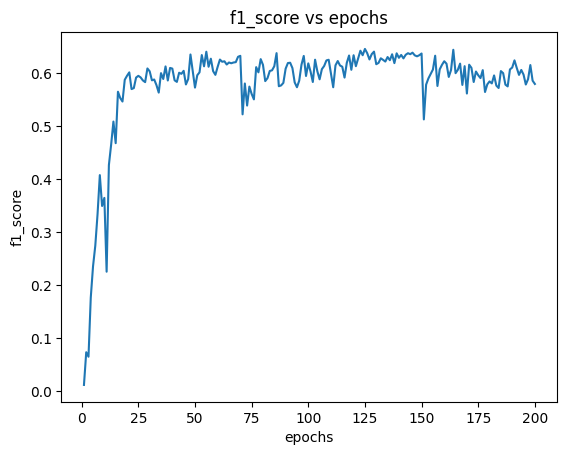

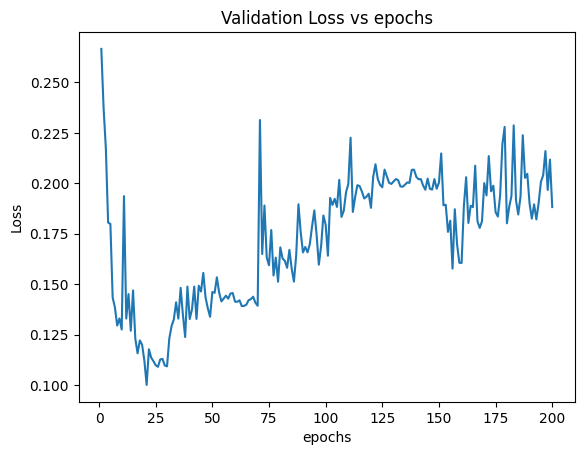

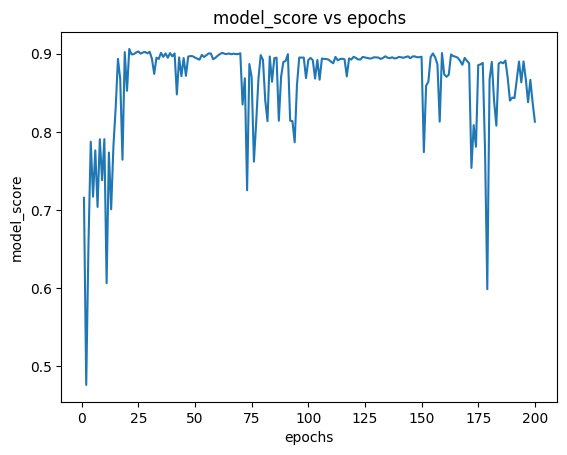

In [6]:
k = len(f1_arr)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,k+1), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms) 

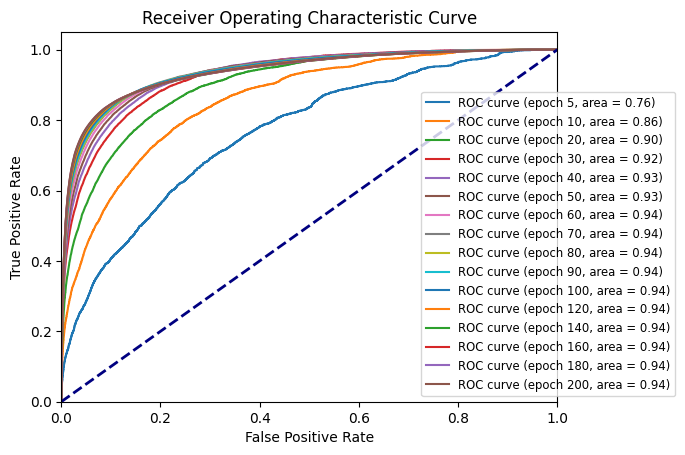

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [8]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:07<00:00,  3.80it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.5167    0.6667  0.6667  0.9474
      1       0.35      0.3333  0       0.8421
      2       0.6833    0.6667  1       1
      3       0.35      0.3333  0       0.7895
      4       0.525     0.5     0       1
      5       0.6833    0.6667  1       1
      6       0.6833    0.6667  1       1
      7       0.525     0.5     0       1
      8       0.5167    0.6667  0.6667  1
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.35      0.3333  0       0.9474
     13       0.5167    0.6667  0.6667  1
     14       0.6833    0.6667  1       1
     15       0.35      0.3333  0       0.9474
     16       0.35      0.3333  0       0.7368
     17       0.35      0.3333  0       0.7368
     18       0.6833    0.6667  1       1
     19       0.7       0.6667  1       1
